# Saving `dysh` data to external files
This notebook gives examples of how to write out selected data from [`GBTFitsLoad`](https://dysh.readthedocs.io/en/latest/modules/dysh.fits.html#module-dysh.fits.gbtfitsload) and how to save 
[`Spectrum`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.spectrum), 
[`Scan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#module-dysh.spectra.scan), and 
[`ScanBlock`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.ScanBlock) to different formats.

In [1]:
from dysh.fits.gbtfitsload import GBTFITSLoad
from dysh.spectra.spectrum import Spectrum
from dysh.util.download import from_url
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

## Data Retrieval

Download the example SDFITS data, if necessary.

In [2]:
url = "http://www.gb.nrao.edu/dysh/example_data/positionswitch/data/AGBT05B_047_01/AGBT05B_047_01.raw.acs/AGBT05B_047_01.raw.acs.fits"
savepath = Path.cwd() / "data"
filename = from_url(url, savepath)

## Data Loading

Next, we use `GBTFITSLoad` to load the data, and then its `summary` method to inspect its contents.

In [3]:
sdfits = GBTFITSLoad(filename)
sdfits.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,51,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,198.343112,18.64274
1,52,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,198.930571,18.787219
2,53,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,199.330491,18.356075
3,54,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,199.915725,18.492742
4,55,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,200.304237,18.057533
5,56,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,200.890603,18.186034
6,57,NGC5291,4386.0,OnOff,1,1.420405,1.420405,1,2,11,1,202.327548,17.385267
7,58,NGC5291,4386.0,OnOff,2,1.420405,1.420405,1,2,11,1,202.919161,17.494902


### Calibrate a position switched scan.  

This returns a `ScanBlock` containing one [`PSScan`](https://dysh.readthedocs.io/en/latest/modules/dysh.spectra.html#dysh.spectra.scan.PSScan) with 11 integrations for the ON position and 11 integrations for the OFF position.

In [4]:
ps_scan_block = sdfits.getps(scan=51, ifnum=0, plnum=0, fdnum=0)

In [5]:
print(f"Number of integrations = {ps_scan_block[0].nrows}")

Number of integrations = 22


## Get the time average of the calibrated data
This method returns a `Spectrum`.

In [6]:
ta = ps_scan_block.timeaverage()

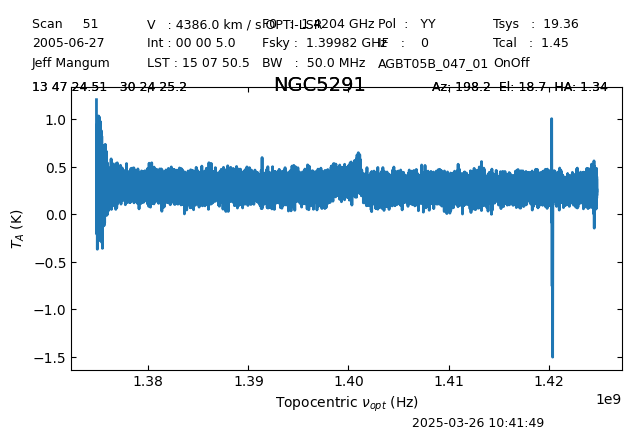

In [7]:
ta.plot()

---

## Reading and Writing Individual Spectra

###  Inputs and Outputs
`dysh` supports output to text files in a variety of [formats familiar to users of astropy](https://docs.astropy.org/en/stable/io/ascii/index.html#id1):
* basic
* commented_header
* ECSV
* fixed_width
* IPAC
* MRT
* votable

In [8]:
fmt = [ 
    "basic",
    "commented_header",
    "ecsv",
    "fixed_width",
    "ipac",
    "mrt",
    "votable",
]
output_dir = Path.cwd() / "output"
for f in fmt:
    file = output_dir / f"testwrite.{f}"
    ta.write(file, format=f, overwrite=True)


We can also write a spectrum to FITS format.

In [9]:
ta.write(output_dir / "testwrite.fits", format="fits", overwrite=True)

We can read spectra in FITS and a few formats. [As noted in astropy, ECSV ](https://docs.astropy.org/en/stable/io/ascii/ecsv.html#ecsv-format) is the only ASCII format that can make a lossless output-input roundtrip and thus reproduce an original spectrum.

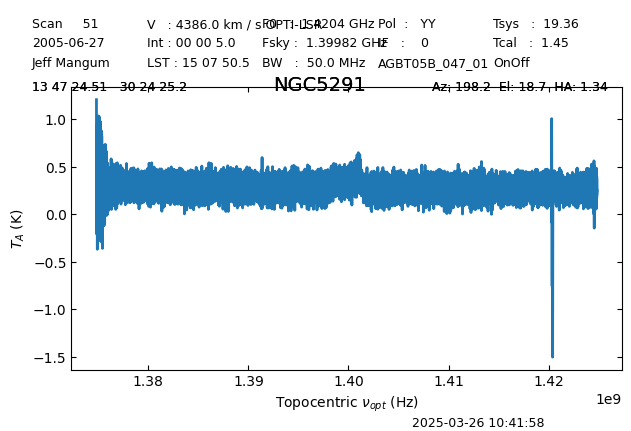

In [10]:
s1 = Spectrum.read(output_dir / "testwrite.fits", format="fits")
s1.plot()

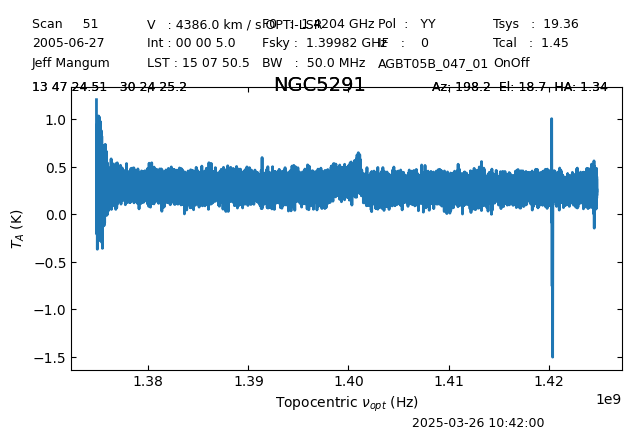

In [11]:
s2 = Spectrum.read(output_dir / "testwrite.ecsv", format="ecsv")
s2.plot()

### GBTIDL ASCII format
`dysh` can read text files created by GBTIDL's `write_ascii` function. However, those files do not provide sufficient metadata to fully recreate the spectrum.  (For instance, they do not have complete sky coordinate information.)  

In [12]:
url = "https://www.gb.nrao.edu/dysh/example_data/onoff-L/gbtidl-data/onoff-L_gettp_156_intnum_0_HEL.ascii"
filename_ascii = from_url(url, savepath)
s3 = Spectrum.read(filename_ascii, format='gbtidl')

In [13]:
print(s3, "\n", s3.meta)

Spectrum1D (length=32768)
Flux=[3608710. 3553598. 3604808. ... 3523171. 3545982. 3474847.] ct,  mean=493422767.43425 ct
Spectral Axis=[1.42009237 1.42009166 1.42009094 ... 1.39665654 1.39665582
               1.39665511] GHz,  mean=1.40837 GHz 
 {'SCAN': 156, 'OBJECT': 'NGC2782', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 119.42083333333332, 'VELDEF': 'None-HEL', 'POL': 'YY'}


`dysh` can even read compressed ASCII files. Note these data have velocity on the spectral axis.

In [14]:
url = "https://www.gb.nrao.edu/dysh/example_data/onoff-L/gbtidl-data/onoff-L_getps_152_RADI-HEL.ascii.gz"
filename_ascii_gz = from_url(url, savepath)
s4 = Spectrum.read(filename_ascii_gz, format='gbtidl')

In [15]:
print(s4, "\n", s4.meta)

Spectrum1D (length=32768)
Flux=[-0.1042543   0.05250004  0.00432693 ... -0.05038555  0.03408394
       0.06139921] K,  mean=0.17345 K
Spectral Axis=[1281.15245599 1281.30342637 1281.45439674 ... 6227.69690405
               6227.84787443 6227.99884481] km / s,  mean=3754.57565 km / s 
 {'SCAN': 152, 'OBJECT': 'NGC2415', 'DATE-OBS': '2021-02-10 00:00:00.000', 'RA': 114.65624999999999, 'VELDEF': 'RADI-HEL', 'POL': 'YY'}


#### Plot 
To plot the spectrum contained in the ascii files you have to use `matplotlib`.

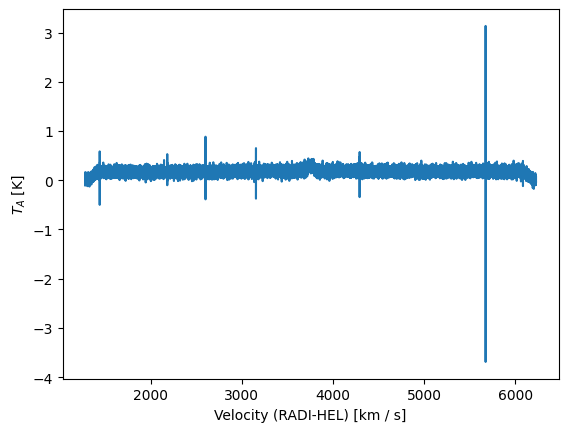

In [16]:
plt.figure()
plt.xlabel(f"Velocity ({s4.meta['VELDEF']}) [{s4.spectral_axis.unit}]")
plt.ylabel(f"$T_A$ [{s4.flux.unit}]")
plt.plot(s4.spectral_axis, s4.flux)

---

## Writing Calibrated Data to SDFITS
You can write the calibrated data from a ScanBlock in SDFITS format.  If there are multiple Scans in the ScanBlock, they will all be written to the same binary table (useful for `gbtgridder`).

In [17]:
ps_scan_block.write(output_dir / "scanblock.fits", overwrite=True)

---

## Writing out selected data from `GBTFITSLoad`
The `write()` method of `GBTFITSLoad` supports down-selection of data. Data can be selected on any SDFITS column.

In [18]:
sdfits.write(output_dir / "mydata.fits", plnum=1, ifnum=[0,2], 
             intnum=np.arange(100), overwrite=True, multifile=False)

 ID    TAG    IFNUM PLNUM               INTNUM              # SELECTED
--- --------- ----- ----- --------------------------------- ----------
  0 4dde4cef2 [0,2]     1 [ 0  1  2  3  4...\n 96 97 98 99]        176


        Use update_header instead. [dysh.fits.sdfitsload]
        Use update_header instead. [dysh.fits.sdfitsload]


These data, can of course, be read back in.

In [19]:
sdfits2 = GBTFITSLoad(output_dir / "mydata.fits")

### Writing SDFITS to multiple files 
If the data came from multiple files, for instance VEGAS banks, then by default they are written to multiple files, so
`sdfits.write('mydata.fits') `
would write to mydata0.fits, mydata1.fits, ... mydataN.fits.
A future enhancement will preserve the A,B,C alphabetic extensions of the input data.